In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import clip
import re
import time
import yaml
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from networks import SCLIPNN

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading Models")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

Loading Models


In [3]:
import yaml
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
dirname = cfg["dataset"]["dirname"]
train_path = 'train_sentences.txt'
test_path = 'test_sentences.txt'
valid_path = 'valid_sentences.txt'
train_filename = dirname + '/' + train_path
test_filename = dirname + '/' + test_path
valid_filename = dirname + '/' + valid_path

In [4]:
train_sentences = []
with open(train_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        train_sentences.append(line)
N = len(train_sentences)
print("Number of sentences to train: {}".format(N))

Number of sentences to train: 5021


In [5]:
valid_sentences = []
with open(valid_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        valid_sentences.append(line)
N = len(valid_sentences)
print("Number of sentences to valid: {}".format(N))

Number of sentences to valid: 1006


In [6]:
test_sentences = []
with open(test_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        test_sentences.append(line)
N = len(test_sentences)
print("Number of sentences to test: {}".format(N))

Number of sentences to test: 1002


In [7]:
regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
for r in regex:
    train_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), train_sentences))
    valid_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), valid_sentences))
    test_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), test_sentences))
train_text = clip.tokenize(train_sentences).to(device)
valid_text = clip.tokenize(valid_sentences).to(device)
test_text = clip.tokenize(test_sentences).to(device)

In [8]:
print("CLIP encoding...")
with torch.no_grad():
    train_clip_embeddings = clip_model.encode_text(train_text)

CLIP encoding...


In [9]:
with torch.no_grad():
    valid_clip_embeddings = clip_model.encode_text(valid_text)
    test_clip_embeddings = clip_model.encode_text(test_text)

In [10]:
print("SBERT encoding...")
with torch.no_grad():  
    train_sbert_embeddings = torch.from_numpy(sbert_model.encode(train_sentences))
    valid_sbert_embeddings = torch.from_numpy(sbert_model.encode(valid_sentences))
    test_sbert_embeddings = torch.from_numpy(sbert_model.encode(test_sentences))

SBERT encoding...


In [11]:
print("-"*10)
for sentence, train_clip_embedding, train_sbert_embedding in zip(train_sentences[:1], train_clip_embeddings[:1], train_sbert_embeddings[:1]):
    print("Sentence:", sentence)
    input_size = train_sbert_embedding.size()[0]    
    print("Sbert Embedding: ", input_size)
    print("Clip Embedding: ", train_clip_embedding.size()[0])
    print("-"*10)

----------
Sentence: A bicycle replica with a clock as the front wheel 
Sbert Embedding:  512
Clip Embedding:  512
----------


In [12]:
print("Creating Models to train...")
model = SCLIPNN(input_size, 850).to(device)

Creating Models to train...


In [13]:
params = cfg["training"]

def train(model, train_sbert_embeddings, train_clip_embeddings, test_sbert_embeddings, test_clip_embeddings,
          valid_sbert_embeddings, valid_clip_embeddings, epochs=params["epochs"], print_every=params["print_every"]):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    train_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        model.train()
        for inputs, labels in zip(train_sbert_embeddings, train_clip_embeddings):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        for inputs, labels in zip(test_sbert_embeddings, test_clip_embeddings):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        for inputs, labels in zip(valid_sbert_embeddings, valid_clip_embeddings):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss)
        if (epoch % print_every == 0) or (epoch == epochs - 1):
            print("Epoch {}. Loss: {}".format(epoch, train_loss))
    
    return train_losses

In [14]:
name = "best_model"
start_time = time.time()
print('Training model {}'.format(name))
train_loss = train(model, train_sbert_embeddings, train_clip_embeddings, 
                    test_sbert_embeddings, test_clip_embeddings,
                    valid_sbert_embeddings, valid_clip_embeddings)
torch.save(model.state_dict(), "models/best_model.pt")
final_loss = round(train_loss[-1],3)
end_time = time.gmtime(time.time() - start_time)
elapsed_time = time.strftime("%H:%M:%S", end_time)
print('Finished Training from model {}. Elapsed time: {}.'.format(name,elapsed_time))
print("-"*50)
actual_time = time.strftime("%Y/%m/%d, %H:%M:%S", time.gmtime(time.time()))
print("End of Training Process on {}".format(actual_time))

Training model best_model
Epoch 0. Loss: 715.0933513082686
Epoch 50. Loss: 302.38726556982175
Epoch 100. Loss: 261.03504874685103
Epoch 150. Loss: 237.3811235171139
Epoch 200. Loss: 222.0983095792502
Epoch 250. Loss: 211.19220557843803
Epoch 300. Loss: 203.0065917971902
Epoch 350. Loss: 196.60234039811692
Epoch 399. Loss: 191.5307025787919
Finished Training from model best_model. Elapsed time: 01:42:23.
--------------------------------------------------
End of Training Process on 2022/03/16, 18:52:35


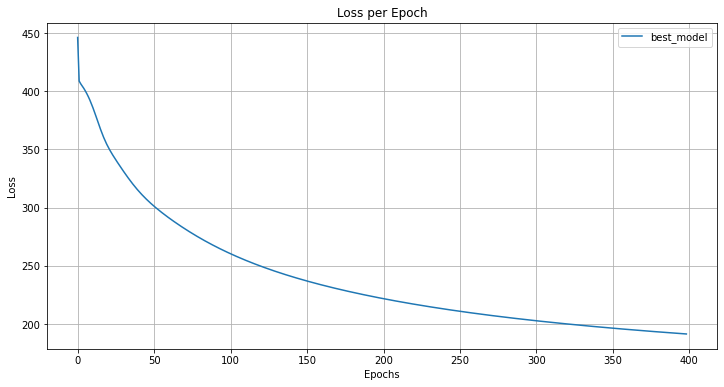

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss[1:], label = name)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid()
plt.show()

In [16]:
def cosin_calculator(targets, predictions):    
    cosines = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for tar, pred in zip(targets, predictions):        
        cosine = cos(tar, pred)
        cosines.append(cosine.item())
    return np.array(cosines)

In [17]:
def evaluate(model, test_clip_embeddings, test_sbert_embeddings):
    cosines = []
    euclideans = []
    with torch.no_grad():
        sum_cos = 0
        count = 0
        predictions =[]
        for tclip, tsbert in zip(test_clip_embeddings, test_sbert_embeddings):        
            tclip = tclip.to(device)
            tsbert = tsbert.to(device)
            prediction = model(tsbert)
            predictions.append(prediction)
            sum_cos += np.mean(cosin_calculator(tclip, prediction))
            count += 1
        cosines.append(round(sum_cos/count,3))
        stacked_predictions = torch.stack(predictions)
        euclidean = torch.cdist(test_clip_embeddings.to(float), stacked_predictions.to(float))
        avg_euclidean = torch.mean(euclidean)
        euclideans.append(round(avg_euclidean.item(),3))    
    return cosines, euclideans

In [18]:
print("Evaluating...")
start_time = time.time()
cosines, euclideans = evaluate(model,test_clip_embeddings, test_sbert_embeddings)
end_time = time.gmtime(time.time() - start_time)
evaluation_time = time.strftime("%H:%M:%S", end_time)
print("Evaluation Time: {}".format(evaluation_time))

Evaluating...
Evaluation Time: 00:02:22


In [19]:
data = {"Cosin":cosines, "Euclidean":euclideans, 
        "TrainTime":[elapsed_time], "ValLoss":[final_loss]}
results = pd.DataFrame(data, index=[name])

In [20]:
results

,Cosin,Euclidean,TrainTime,ValLoss
best_model,0.583,6.556,01:42:23,191.531
